# Transition to Polynomial Regression

### Objective

We aim to enhance the predictive performance of our model by transitioning from linear to polynomial regression combined with logistic regression. This approach allows us to capture non-linear relationships between features and the target variable (vaccine_response) in the FluPRINT dataset.

### Methodology

1.  Polynomial Feature Transformation: We use degrees 1 and 2 to test both linear and quadratic relationships.
2. Model Evaluation: Cross-validation is performed to evaluate model performance using the F1 macro score.
3. Final Model Testing: The best-performing degree is selected and tested on a separate dataset.

### Rationale
Polynomial regression can better capture complex interactions in the data, potentially improving classification accuracy compared to linear models. 

---

## Step 1- Setup and Data Loading

First, we'll import the required libraries and load our preprocessed data.

In [33]:
import pandas as pd
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import seaborn as sns

In [23]:
path_to_fluprint = r"C:\Users\Dana\OneDrive\Documents\Applied Data science\FluPRINT_database\FluPRINT_filtered_data\aggregated_participants.csv"
fluprint_data = pd.read_csv(path_to_fluprint)

## Step 2 - Polynomial Regression

This code evaluates the performance of polynomial regression combined with logistic regression for predicting vaccine_response using the single feature d_geo_mean, which represents the titre difference between pre- and post-vaccination.

Polynomial features are generated for degrees 1 and 2 to compare linear and quadratic relationships. Testing higher-degree polynomials is avoided at this stage to reduce the risk of overfitting, as simpler models are often more generalisable. Cross-validation with 5 folds is used to evaluate model performance, with the F1 macro score chosen as the metric to account for potential class imbalance in the dataset.

This process helps determine whether incorporating non-linear relationships improves prediction accuracy compared to a simple linear model.

In [ ]:
X = fluprint_data[["d_geo_mean"]]
y = fluprint_data["vaccine_response"]

degrees = [1,2]

for degree in degrees:
    poly_model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LogisticRegression(class_weight = "balanced", max_iter = 1000)
    )

    scores = cross_val_score(poly_model, X, y, cv=5, scoring = "f1_macro")

    print(f"Degree {degree} polynomial:")
    print(f"Mean F1 score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    print()

best_degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

first_poly_model = make_pipeline(
    PolynomialFeatures(degree=best_degree, include_bias=False),
    LogisticRegression(class_weight='balanced', max_iter=1000)
)

first_poly_model.fit(X_train, y_train)
y_pred = first_poly_model.predict(X_test)

print("Best polynomial model performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Degree 1 polynomial:
Mean F1 score: 0.636 (+/- 0.132)

Degree 2 polynomial:
Mean F1 score: 0.647 (+/- 0.123)

Best polynomial model performance:
Accuracy: 0.71
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.78        38
         1.0       0.61      0.52      0.56        21

    accuracy                           0.71        59
   macro avg       0.68      0.67      0.67        59
weighted avg       0.70      0.71      0.71        59



### Results Overview

#### Cross-Validation Results
- **Degree 1 Polynomial**: Mean F1 score of 0.636 with a margin of error of +/- 0.132.
- **Degree 2 Polynomial**: Mean F1 score of 0.647 with a margin of error of +/- 0.123.

#### Best Polynomial Model Performance (Degree 2)
- **Accuracy**: 0.71
- **Class 0.0**: Precision 0.76, Recall 0.82, F1-score 0.78, Support 38.
- **Class 1.0**: Precision 0.61, Recall 0.52, F1-score 0.56, Support 21.
- **Macro Average**: Precision 0.68, Recall 0.67, F1-score 0.67.
- **Weighted Average**: Precision 0.70, Recall 0.71, F1-score 0.71.

#### Interpretation
The degree 2 polynomial model slightly outperforms the degree 1 model in terms of mean F1 score from cross-validation and also has a similar accuracy to the logistic regression model (*logistic_regression -Step 6*). The model performs better on class 0.0 than on class 1.0, indicating potential class imbalance issues. The macro average F1 score (0.67) is lower than the weighted average (0.71), suggesting that the model's performance is influenced by the class distribution.

---

## Step 3 - Polynomial Model with SMOTE

In [14]:
# Load the dataset
X = fluprint_data[["d_geo_mean"]]
y = fluprint_data["vaccine_response"]

# Define polynomial degrees to test
degrees = [1, 2]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Loop through each degree and evaluate the model
for degree in degrees:
    # Create polynomial features for resampled training data
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_resampled)
    
    # Fit logistic regression on resampled data with polynomial features
    clf = LogisticRegression(class_weight="balanced", max_iter=1000)
    clf.fit(X_train_poly, y_train_resampled)
    
    # Evaluate on test data (apply same polynomial transformation)
    X_test_poly = poly.transform(X_test)
    y_pred = clf.predict(X_test_poly)
    
    print(f"Degree {degree} polynomial with SMOTE:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(classification_report(y_test, y_pred))

Degree 1 polynomial with SMOTE:
Accuracy: 0.76
              precision    recall  f1-score   support

         0.0       0.77      0.89      0.83        38
         1.0       0.73      0.52      0.61        21

    accuracy                           0.76        59
   macro avg       0.75      0.71      0.72        59
weighted avg       0.76      0.76      0.75        59

Degree 2 polynomial with SMOTE:
Accuracy: 0.71
              precision    recall  f1-score   support

         0.0       0.76      0.82      0.78        38
         1.0       0.61      0.52      0.56        21

    accuracy                           0.71        59
   macro avg       0.68      0.67      0.67        59
weighted avg       0.70      0.71      0.71        59



### Overall Performance:
- **Accuracy**: 0.76

### Class-Specific Performance:
- **Low Responders (Class 0):**
  - **Recall: 89%**: Good at identifying true low responders. The model is relatively more sensitive to this class.
  - **Precision: 77%**: Indicates that some individuals are incorrectly classified as low responders, leading to false positives. 
- **High Responders (Class 1):**
  - **Recall: 52%**: Significantly lower, meaning the model misses a large portion of true high responders.
  - **Precision: 73%**: Suggests that when the model *does* predict someone as a high responder, it's more likely to be correct. However, it's not predicting this class frequently enough.

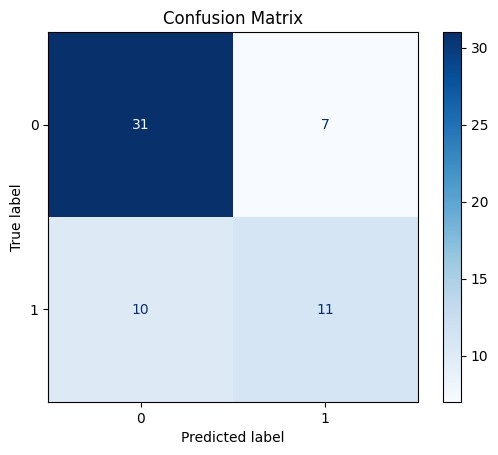

In [20]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

**Interpretation:**  The model excels at identifying Low Responders but struggles with High Responders.

### Key Observations:
- **Focus on Recall for High Responders:** The primary issue isn't the *accuracy* of predicting High Responders (precision is decent), but the *frequency* (recall is low). The model is too conservative in predicting this class.
- **True Positive Bottleneck:** The model struggles to reliably distinguish true positives (high responders) from false negatives.
- **Trade-off Between Classes:** The confusion matrix highlights the trade-off: improving recall for Class 1 likely means accepting more false positives for Class 0.

### Why is SMOTE Not Fully Addressing Imbalance?
Despite using SMOTE, the imbalance issue persists. Possible reasons:
1. **Feature Overlap:** If the features of the minority class (high responders) overlap significantly with the majority class (low responders), SMOTE may generate synthetic samples that are difficult for the model to differentiate. These may effectively add noise and not genuinely improve separability.
2. **Data Complexity:** The underlying relationships between features and vaccine response may be more complex than a simple polynomial logistic regression can capture, even with SMOTE-enhanced data.  The limited feature set (`d_geo_mean`) could be a contributing factor, preventing SMOTE from working effectively.
3. **SMOTE Limitations:** SMOTE creates synthetic samples by interpolating between existing minority class instances. If the original minority class instances are themselves quite diverse, the generated samples might not accurately represent the full spectrum of high responders.

### Next Steps:
1. **Adjust Classification Threshold**: Experiment with lower thresholds to increase sensitivity towards high responders.
2. **Explore Other Models**: Consider tree-based algorithms or other models more capable of handling imbalanced data and complex relationships.
3. **Advanced Resampling**: Look into combining SMOTE with under-sampling techniques (e.g., SMOTE-Tomek links) to potentially remove noisy samples and improve class separation.
4. **Feature Importance**: Investigate feature importance to determine if `d_geo_mean` is overshadowing other potential predictors or if additional features are necessary.
5. **Further Feature Engineering**: Attempt to generate new features from existing ones to better capture the immune response. Consider the ratio of antibody titers, or differences in other immune markers.

---

## Step 4 - Incorporating more features 
Like in the previous notebook, we will try to improve the model's performance and potentially mitigate class imbalance issues, additional features (`visit_age`, `gender`, and `race`) are included in the model. While these features do not directly address class imbalance, they provide more information that can help the model better distinguish between classes. The use of balanced class weights in logistic regression (`class_weight="balanced"`) is a direct approach to handling class imbalance.

**Note:**
Considering the last time we have tried this (`logistic_regression Step 7`), the accuracy decreased the accuracy, there is a high likelihood it will do the same in this case.

In [21]:
# Select relevant features and one-hot encode categorical variables
X = pd.get_dummies(fluprint_data[["d_geo_mean", "visit_age", "gender", "race"]], columns=["gender", "race"], drop_first=True)
y = fluprint_data["vaccine_response"]

# Define the polynomial degrees to test
degrees = [1,2]

# Loop through each degree and evaluate the model
for degree in degrees:
    poly_model = make_pipeline(
        PolynomialFeatures(degree=degree, include_bias=False),
        LogisticRegression(class_weight = "balanced")
    )

    scores = cross_val_score(poly_model, X, y, cv=5, scoring = "f1_macro")

    print(f"Degree {degree} polynomial:")
    print(f"Mean F1 score: {scores.mean():.3f} (+/- {scores.std() * 2:.3f})")
    print()


# Select the best polynomial degree based on cross-validation results
best_degree = 2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Split the dataset into training and testing sets
second_poly_model = make_pipeline(
    PolynomialFeatures(degree=best_degree, include_bias=False),
    LogisticRegression(class_weight='balanced', max_iter=1000, C=0.01)
)

# Fit the model to the training data
second_poly_model.fit(X_train, y_train)

# Predict the test data
y_pred = second_poly_model.predict(X_test)

# Evaluate the model's performance on the test set
print("Best polynomial model performance:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print(classification_report(y_test, y_pred))

Degree 1 polynomial:
Mean F1 score: 0.638 (+/- 0.119)

Degree 2 polynomial:
Mean F1 score: 0.642 (+/- 0.121)



C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Dana\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable

Best polynomial model performance:
Accuracy: 0.73
              precision    recall  f1-score   support

         0.0       0.81      0.76      0.78        38
         1.0       0.61      0.67      0.64        21

    accuracy                           0.73        59
   macro avg       0.71      0.71      0.71        59
weighted avg       0.74      0.73      0.73        59



###  Performance Breakdown:
-   **Low Responders (Class 0):**
    *   **Precision: 81%**: When the model predicts a low responder, it's correct 81% of the time.
    *   **Recall: 76%**: The model identifies 76% of all actual low responders.

-   **High Responders (Class 1):**
    *   **Precision: 61%**: When the model predicts a high responder, it's correct 61% of the time.
    *   **Recall: 67%**: The model identifies 67% of all actual high responders.

### Key Observations & Interpretations:
*   **Limited Improvement with Added Features**: Adding demographic features (`visit_age`, `gender`, `race`) did *not* lead to a significant improvement in model performance compared to using only `d_geo_mean`. This may indicate:

    1.  **Feature Irrelevance:** The added features are not strong predictors of vaccine response, or they are redundant with `d_geo_mean`.
    2.  **Feature Interactions:** The relationship between the features and the target is more complex than the model can capture (e.g., non-linear interactions).

*   **Persistent Class Imbalance Challenge:** Despite using `class_weight='balanced'`, the model still struggles to achieve high recall for the minority class (High Responders).

*   **Convergence Warnings**: The `ConvergenceWarning` messages suggest that the logistic regression solver did not converge within the maximum iterations. This can be caused by:

    1.  **Unscaled Data**: The features have different scales, which can make optimization difficult.
    2.  **Multicollinearity:** High correlation between features can cause instability in the optimization process. Polynomial features can exacerbate this.

*   **Regularization (C=0.01):** The low value of C indicates strong regularization. Regularization prevents overfitting, but too much may impede the model’s ability to capture the underlying relationships in the data, especially with interactions from polynomial features.


### Conclusion:

While adding more features seemed like a promising approach, it did not yield a significant improvement in model performance in this case. The model is still struggling with the class imbalance, and there are potential issues with feature scaling and convergence. Focus on data preprocessing, feature selection/engineering, model tuning, and explore alternative models.

---